<a href="https://colab.research.google.com/github/VAHIDI1998/Supervise-Text-Classification/blob/main/animal_face_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image classifiacation with pytorch Api
### steps for implementation projects
* download dataset from kaggle
* Importing esentioal library
* ....

In [ ]:
!pip install opendatasets --quiet

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import packageS
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
from PIL import Image


## set device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Extract data files

In [ ]:
images_path = []
labels = []

for i in  os.listdir('/content/animal-faces/afhq'):
 # print(i)
  for label in os.listdir(f'/content/animal-faces/afhq/{i}'):
    # print(label)
    for image in os.listdir('/content/animal-faces/afhq' + '/' + i + '/' + label):
      images_path.append(f'/content/animal-faces/afhq/{i}/{label}/{image}')
      labels.append(label)


In [ ]:
print(len(images_path))
print(len(labels))

16130
16130


## convert to DataFrame format

In [ ]:
df = pd.DataFrame(zip(images_path, labels), columns=['image_paths', 'labels'])
df.head()

,image_paths,labels
0,/content/animal-faces/afhq/train/wild/flickr_w...,wild
1,/content/animal-faces/afhq/train/wild/pixabay_...,wild
2,/content/animal-faces/afhq/train/wild/flickr_w...,wild
3,/content/animal-faces/afhq/train/wild/flickr_w...,wild
4,/content/animal-faces/afhq/train/wild/pixabay_...,wild


### Split data
* This section we try split data into three step
* train - validation - test
* 70%  - 15%  - 15%

In [ ]:
torch.manual_seed(42)
train_df = df.sample(frac=0.7, random_state=7) # 70%
test_df = df.drop(train_df.index)  # 15 %

val_df = test_df.sample(frac=0.5, random_state=7)
test_df= test_df.drop(val_df.index)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)


(11291, 2)
(2419, 2)
(2420, 2)


### Preprocessing objects
* This section we convert string classes to numeric class

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(df['labels'])

LabelEncoder()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
df.shape

(16130, 2)

In [ ]:
labels = torch.tensor(label_encoder.transform(df['labels']), dtype=torch.float32)
labels.dtype

torch.float32

In [ ]:
# Define Custom datasets
class CustomImageDS(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    # convert labels to tensor
    self.labels = torch.tensor(label_encoder.transform(self.df['labels'])).to(device)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    image_path = self.df.iloc[idx, 0]
    labels = self.labels[idx]
    image = Image.open(image_path).convert('RGB')

    # set to transform
    if self.transform is not None:
      image = self.transform(image).to(device)


    return image, labels



In [ ]:
train_set = CustomImageDS(train_df, transform=transform)
test_set = CustomImageDS(test_df, transform=transform)
val_set = CustomImageDS(val_df, transform=transform)


In [ ]:
train_set.__getitem__(0)[1]

tensor(1, device='cuda:0')

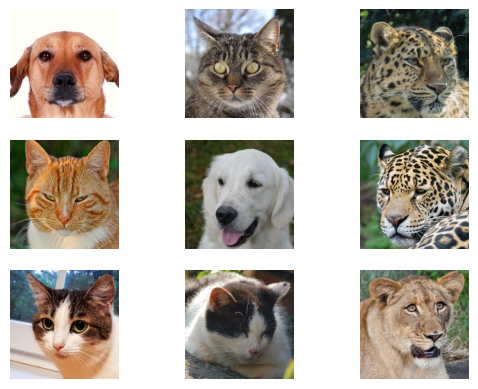

In [ ]:
n_row = 3
n_col = 3

fig ,ax = plt.subplots(n_row, n_col)
for row in range(n_row):
  for col in range(n_col):
    image = Image.open(df.sample(n=1)['image_paths'].iloc[0])
    ax[row , col].imshow(image)
    ax[row, col].axis('off')

In [ ]:
# Tune hyperparameters
LR = 1e-4
Batch_size= 32
Epochs = 10

In [ ]:
# Define Dataloader

train_loader = DataLoader(train_set, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=Batch_size, shuffle=True)


In [ ]:
df['labels'].unique()

array(['wild', 'cat', 'dog'], dtype=object)

In [ ]:
# Define cnn model from scratch
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1), # outputs:(32, 128, 128)
        nn.MaxPool2d(2,2),                          # outputs:(32, 64, 64)
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),  # outputs:(64, 64, 64)
        nn.MaxPool2d(2,2),                            #  outputs:(64, 32, 32)
        nn.ReLU()

    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1), # outputs:(128, 32, 32)
        nn.MaxPool2d(2,2),                            # outputs:(128, 16, 16)
        nn.ReLU()

    )

    self.fc = nn.Sequential(
        nn.Flatten(),             #  128 * 16 * 16 --. flat
        nn.Linear((128 * 16 * 16), 128),
        nn.Linear(128, len(df['labels'].unique()))   # 128 to 3
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.fc(x)

    return x

In [ ]:
model = Net().to(device)
model

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
# Model Summary
from torchsummary import summary
summary(model, input_size=(3 ,128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
output = model(img)

In [ ]:
label.shape, output.shape

(torch.Size([32]), torch.Size([32, 3]))

In [ ]:
# training
total_loss_train_plot= []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []
best_val_loss = 100
for epoch in range(Epochs):
  model.train()
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0
  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) ==  labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  model.eval()

  with torch.no_grad():
    for inputs ,labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc


  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))
  ## acc
  total_acc_train_plot.append(round(total_acc_train/(len(train_set))*100, 4))
  total_acc_val_plot.append(round(total_acc_val/(len(val_set))*100, 4))

  if total_loss_val < best_val_loss:
    best_val_loss = total_loss_val
    print('save model!!')
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/Modern computer vision  hub/model_animal_face_class2.pth')

  print(
      f'Epoch {epoch+1}/{Epochs}\t'
      f'Train_loss: {round(total_loss_train/100, 4)}\t'
      f'Train Accuracy :{round((total_acc_train)/train_set.__len__() * 100, 4)}\t'
      f' Validation Loss: {round(total_loss_val/100, 4)}\t'
      f'Validation Accuracy: {round((total_acc_val)/val_set.__len__() * 100, 4)}\t'
      )
  print("="*25)






save model!!
Epoch 1/10	Train_loss: 2.0199	Train Accuracy :74.9092	 Validation Loss: 0.2513	Validation Accuracy: 88.0579	
save model!!
Epoch 2/10	Train_loss: 0.9589	Train Accuracy :89.8769	 Validation Loss: 0.1634	Validation Accuracy: 91.9835	
save model!!
Epoch 3/10	Train_loss: 0.6626	Train Accuracy :93.0033	 Validation Loss: 0.1225	Validation Accuracy: 94.4628	
Epoch 4/10	Train_loss: 0.4711	Train Accuracy :95.368	 Validation Loss: 0.1484	Validation Accuracy: 92.438	
save model!!
Epoch 5/10	Train_loss: 0.335	Train Accuracy :96.6965	 Validation Loss: 0.076	Validation Accuracy: 96.281	
Epoch 6/10	Train_loss: 0.2617	Train Accuracy :97.5024	 Validation Loss: 0.0909	Validation Accuracy: 95.5785	
Epoch 7/10	Train_loss: 0.2231	Train Accuracy :97.8124	 Validation Loss: 0.0856	Validation Accuracy: 95.6198	
save model!!
Epoch 8/10	Train_loss: 0.1696	Train Accuracy :98.3615	 Validation Loss: 0.0756	Validation Accuracy: 96.5289	
save model!!
Epoch 9/10	Train_loss: 0.1249	Train Accuracy :98.8752	 

In [ ]:
# testing

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_set.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")




Accuracy Score is: 96.3621 and Loss is 0.0075


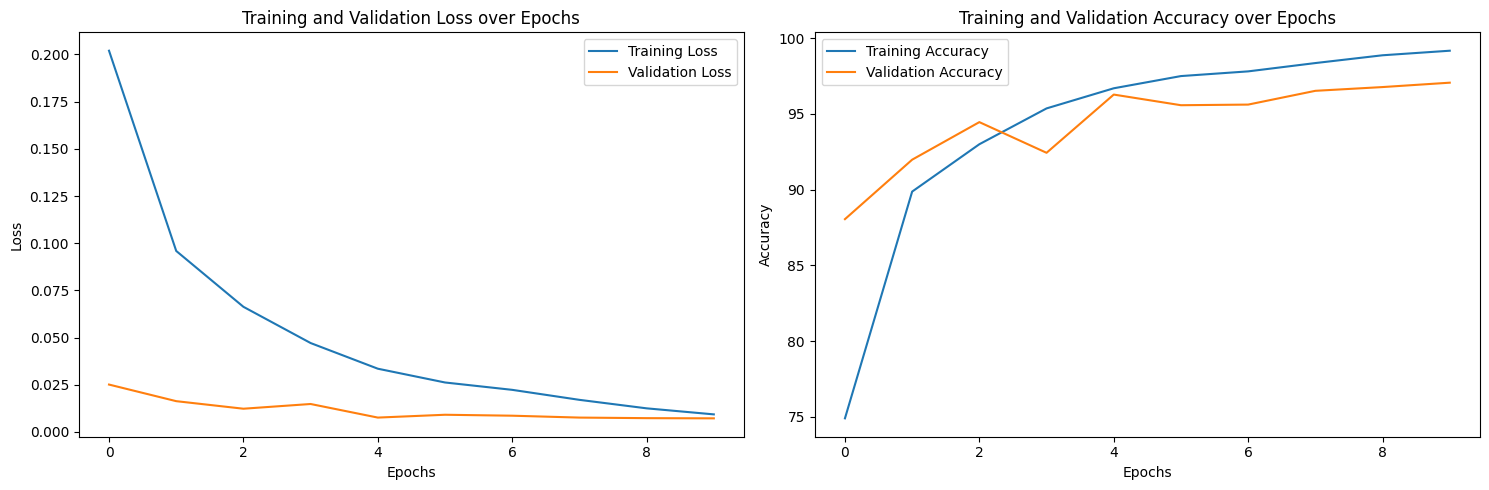

In [ ]:
# Ploting training step progress

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [ ]:
#  create GUI app with Gradio
import gradio as gr
def prediction_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image_t= transform(image).to(device)
  output = model(image_t.unsqueeze(0))
  pred_label = torch.argmax(output, axis=1).item()
  text = label_encoder.inverse_transform([pred_label]).item()  # return numeric value to string class
  return text

In [ ]:
prediction_image('/content/animal-faces/afhq/val/dog/flickr_dog_000054.jpg')

'dog'

In [ ]:

# def prediction_image(image):
#     # image is already a PIL image from Gradio
#     image = image.convert('RGB')
#     image_t = transform(image).to(device)

#     with torch.no_grad():
#         output = model(image_t.unsqueeze(0))

#     pred_label = torch.argmax(output, axis=1).item()
#     label = label_encoder.inverse_transform([pred_label])[0]  # get string label
#     return label

app = gr.Interface(
    fn=prediction_image,
    inputs=gr.Image(type='pil', label='Input Image'),
    outputs=gr.Textbox(label="Predicted Label")
)

app.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://217ee40581381f1c50.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
